In [13]:
import tensorflow as tf
import zipfile
import os
import shutil

In [14]:
img_size = (150, 150)
batch_size = 32

extract_dir = "cat_dog_data"
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
os.makedirs(extract_dir)

train_dir = os.path.join(extract_dir, "train")
val_dir = os.path.join(extract_dir, "validation")
os.makedirs(os.path.join(train_dir, "cats"))
os.makedirs(os.path.join(train_dir, "dogs"))
os.makedirs(os.path.join(val_dir, "cats"))
os.makedirs(os.path.join(val_dir, "dogs"))

with zipfile.ZipFile("cat_dog-train.zip", "r") as z:
    all_files = z.namelist()

    for i, name in enumerate(all_files):
        fname = name.split("/")[-1]
        if fname.startswith("cat."):
            category = "cats"
        elif fname.startswith("dog."):
            category = "dogs"
        else:
            continue

        target_dir = train_dir if i % 5 != 0 else val_dir

        with z.open(name) as source:
            target_path = os.path.join(target_dir, category, fname)
            with open(target_path, 'wb') as target:
                target.write(source.read())

In [15]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary' # or 'categorical' for more than 2 labels
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [16]:
def make_cnn_small_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.binary_crossentropy, metrics=[tf.metrics.binary_accuracy])
    return model

In [17]:
def make_cnn_big_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(512, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dense(2048, activation=tf.nn.relu),
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        #tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid) # instead of softmax since its a binary output
    ])
    model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.binary_crossentropy, metrics=[tf.metrics.binary_accuracy])
    return model

In [18]:
def train(models: list[tf.keras.Model], train_gen, val_gen, epochs=10):
    histories = []
    for model in models:
        history = model.fit(
            train_gen,
            epochs=epochs,
            validation_data=val_gen,
            steps_per_epoch=train_gen.samples // train_gen.batch_size,
            validation_steps=val_gen.samples // val_gen.batch_size
        )
        histories.append(history)
    return histories

In [19]:
def save(models: list[tf.keras.Model]):
    for i in range(len(models)):
        models[i].save(f"model-{i}.keras")

In [20]:
from matplotlib import pyplot as plt
from typing import Any, List, Dict, Union, Optional

HistoryLike = Union[Dict[str, List[float]], Any]


def _detect_accuracy_keys(history: Dict[str, List[float]]):
    candidate_val = next((k for k in history.keys() if k.startswith('val_') and ('acc' in k or 'accuracy' in k)), None)
    if candidate_val:
        train_key = candidate_val[len('val_'):]
        val_key = candidate_val
        if train_key not in history:
            train_key = next((k for k in history.keys() if ('acc' in k or 'accuracy' in k) and not k.startswith('val_')), None)
    else:
        train_key = next((k for k in history.keys() if ('acc' in k or 'accuracy' in k) and not k.startswith('val_')), None)
        val_key = ('val_' + train_key) if train_key and ('val_' + train_key) in history else None
        if not val_key:
            val_key = next((k for k in history.keys() if k.startswith('val_') and ('acc' in k or 'accuracy' in k)), None)
    return train_key, val_key


def plot_histories(histories: list[HistoryLike],
                    model_names: Optional[List[str]] = None,
                    show_train: bool = True,
                    show_val: bool = True,
                    figsize=(10, 6)):
    dicts = []
    for h in histories:
        if hasattr(h, "history"):
            dicts.append(h.history)
        elif isinstance(h, dict):
            dicts.append(h)
        else:
            raise TypeError(f"Unsupported history type: {type(h)}")

    if model_names is None:
        model_names = [f"model-{i}" for i in range(len(dicts))]
    if len(model_names) != len(dicts):
        raise ValueError("`model_names` length must match number of histories.")

    fig, ax = plt.subplots(figsize=figsize)
    for i, hist in enumerate(dicts):
        train_key, val_key = _detect_accuracy_keys(hist)
        name = model_names[i]
        epochs = range(1, max((len(v) for v in hist.values()), default=0) + 1)
        if show_train and train_key and train_key in hist:
            ax.plot(range(1, len(hist[train_key]) + 1), hist[train_key],
                    label=f"{name} train ({train_key})", linestyle='-', marker=None)
        if show_val and val_key and val_key in hist:
            ax.plot(range(1, len(hist[val_key]) + 1), hist[val_key],
                    label=f"{name} val ({val_key})", linestyle='--', marker=None)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title("Training and Validation Accuracy")
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(loc='best', fontsize='small')
    plt.tight_layout()
    return fig, ax


In [21]:
models = [make_cnn_small_model(), make_cnn_big_model()]

In [22]:
output = train(models, train_generator, validation_generator)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - binary_accuracy: 0.6751 - loss: 0.5941 - val_binary_accuracy: 0.7626 - val_loss: 0.4953
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - binary_accuracy: 0.7731 - loss: 0.4772 - val_binary_accuracy: 0.7748 - val_loss: 0.4820
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - binary_accuracy: 0.8119 - loss: 0.4128 - val_binary_accuracy: 0.7815 - val_loss: 0.4671
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - binary_accuracy: 0.8463 - loss: 0.3536 - val_binary_accuracy: 0.7853 - val_loss: 0.4621
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - binary_accuracy: 0.8736 - loss: 0.2961 - val_binary_accuracy: 0.7963 - val_loss: 0.4688
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - binary_accuracy: 0.8992 - loss: 0.2447 - val_binary_accuracy: 0.7951 - val_loss: 0.5063
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - binary_accuracy: 0.9180 - loss: 0.1991 - val_binary_accuracy: 0.7915 - val_loss:

2026-01-12 11:03:13.223638: W external/local_xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 647.73MiB (679190282 bytes) by rematerialization; only reduced to 2.25GiB (2415919104 bytes), down from 2.25GiB (2415919104 bytes) originally
2026-01-12 11:03:14.431507: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 96 bytes spill stores, 96 bytes spill loads

2026-01-12 11:03:14.490201: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2026-01-12 11:03:14.607380: W external/local_xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 647.73MiB (679190282 bytes) by rematerialization; only reduced to 2.27GiB (2441347088 bytes), down from 

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/gabriel/mypy/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/gabriel/mypy/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/gabriel/mypy/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/gabriel/mypy/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.13/asyncio/base_events.py", line 683, in run_forever

  File "/usr/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once

  File "/usr/lib/python3.13/asyncio/events.py", line 89, in _run

  File "/home/gabriel/mypy/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/gabriel/mypy/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/gabriel/mypy/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/gabriel/mypy/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/gabriel/mypy/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/gabriel/mypy/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/gabriel/mypy/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/gabriel/mypy/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/gabriel/mypy/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/gabriel/mypy/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/gabriel/mypy/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/gabriel/mypy/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/gabriel/mypy/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_69230/3411201432.py", line 1, in <module>

  File "/tmp/ipykernel_69230/3261576902.py", line 4, in train

  File "/home/gabriel/mypy/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gabriel/mypy/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/home/gabriel/mypy/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/home/gabriel/mypy/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

Out of memory while trying to allocate 1207959552 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_139881]

In [11]:
save(models)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>)

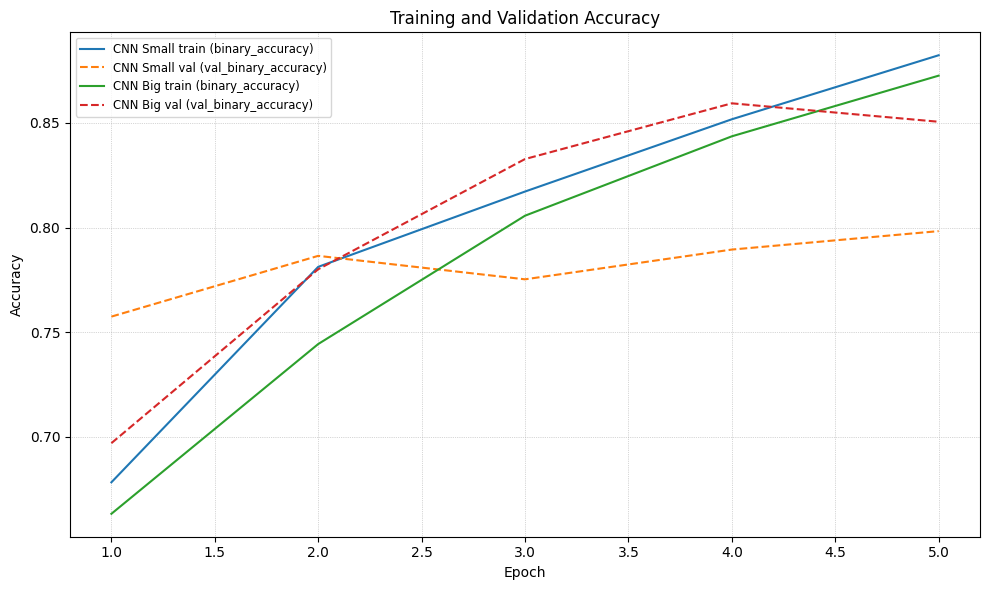

In [12]:
plot_histories(output, ["CNN Small", "CNN Big"])